In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib import colors
import plotly

%matplotlib inline

# Load data

In [11]:
path = "Data/"
sample_submission = pd.read_csv(path + "sample_submission.csv")
app_events = pd.read_csv(path + "app_events.csv")
app_labels = pd.read_csv(path + "app_labels.csv")
events = pd.read_csv(path + "events.csv", dtype = {"device_id": np.str},\
                    infer_datetime_format = True, parse_dates = ["timestamp"])
gender_age_test = pd.read_csv(path + "gender_age_test.csv")
gender_age_train = pd.read_csv(path + "gender_age_train.csv", dtype = {"device_id": np.str, "age": np.int8})
phone_brand_device_model = pd.read_csv(path + "phone_brand_device_model.csv", dtype = {"device_id": np.str},\
                    encoding = "UTF-8")
label_categories = pd.read_csv(path + "label_categories.csv")

# EDA

In [12]:
#labeling train and test data
gender_age_test['test'] = np.arange(gender_age_test.shape[0])
gender_age_train['train'] = np.arange(gender_age_train.shape[0])


In [13]:
# merging datasets and dropping unnecessary items
### events
gender_age_train = gender_age_train.merge(events, how = "left", on = "device_id")

gender_age_train = gender_age_train.merge(phone_brand_device_model, how = "left", on = "device_id")

gender_age_train.drop("device_id", axis = 1, inplace = True)

### app_events
gender_age_train = gender_age_train.merge(app_events, how = "left", on = "event_id")

gender_age_train.drop("event_id", axis = 1, inplace = True)

### app_labels and label_categories
gender_age_train = gender_age_train.merge(app_labels, how = "left", on = "app_id")
gender_age_train = gender_age_train.merge(label_categories, how = "left", on = "label_id")

gender_age_train.drop(["app_id", "label_id"], axis = 1, inplace = True)

print("------------------------------------------------")
print(gender_age_train.head())
print("------------------------------------------------")
print(gender_age_train.info())

------------------------------------------------
  gender  age   group  train           timestamp  longitude  latitude  \
0      M   35  M32-38      0                 NaT        NaN       NaN   
1      M   35  M32-38      1                 NaT        NaN       NaN   
2      M   35  M32-38      2 2016-05-01 14:23:37        0.0       0.0   
3      M   35  M32-38      2 2016-05-01 14:23:37        0.0       0.0   
4      M   35  M32-38      2 2016-05-01 14:23:37        0.0       0.0   

  phone_brand device_model  is_installed  is_active category  
0          小米         MI 2           NaN        NaN      NaN  
1          小米         MI 2           NaN        NaN      NaN  
2          小米         MI 2           1.0        0.0      NaN  
3          小米         MI 2           1.0        0.0      NaN  
4          小米         MI 2           1.0        0.0      NaN  
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13447651 entries, 0 to 13447650
Dat

In [15]:

#data_sets = [sample_submission, app_events, app_labels, events, gender_age_test, gender_age_train, phone_brand_device_model]

#for data in data_sets:
#    print(data.shape)
print(gender_age_train.isnull().sum())    
gender_age_train.shape

gender                 0
age                    0
group                  0
train                  0
timestamp          51439
longitude          51439
latitude           51439
phone_brand            0
device_model           0
is_installed      713679
is_active         713679
category        12910326
dtype: int64


(13447651, 12)

Our goal is to find the probability for each gender and age-range as shown below in sample submission.

In [4]:
sample_submission.head(5)

,device_id,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
0,1002079943728939269,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
1,-1547860181818787117,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
2,7374582448058474277,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
3,-6220210354783429585,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
4,-5893464122623104785,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833


In [5]:
app_events.head(5)

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [33]:
label_categories

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time
5,6,game-Cutting things
6,7,game-Finding fault
7,8,game-stress reliever
8,9,game-pet
9,10,game-Answer


In [54]:
print(str(app_labels.shape))
app_labels.head(5)

(459943, 2)


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [8]:
app_labels.describe()

,app_id,label_id
count,4.599430e+05,459943.000000
mean,1.912461e+17,664.849749
std,5.269442e+18,192.797736
min,-9.223281e+18,2.000000
25%,-4.305882e+18,548.000000
50%,1.083204e+17,714.000000
75%,4.830475e+18,795.000000
max,9.223318e+18,1021.000000


In [9]:
events.head(5)

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [10]:
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='patjar', api_key='token')

df = events.head(10)

mapbox_access_token = 'token'

data = [
    go.Scattermapbox(
        lat= df['latitude'],
        lon= df['longitude'],
        mode='markers',
        marker=dict(
            size=9
        ),
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=115.92,
            lon=36.07
        ),
        pitch=0,
        zoom=10
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

PlotlyRequestError: Aw, snap! You tried to use our API as the user 'patjar', but the supplied API key doesn't match our records. You can view your API key at https://plot.ly/settings/api

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to https://plot.ly/<language>/getting-started (e.g., https://plot.ly/python/getting-started) for more information.

Make sure that you're logged in as patjar.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

In [25]:
gender_age_test.head(5)

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [26]:
gender_age_train.head(5)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


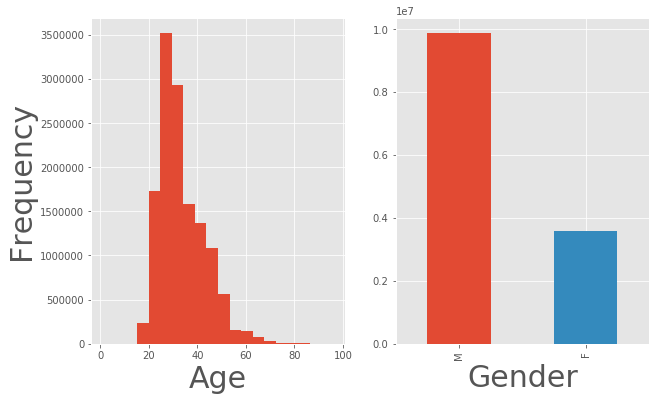

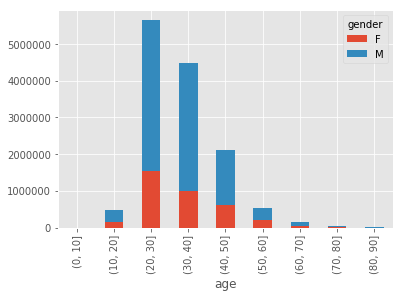

In [64]:
fig, axs = plt.subplots(1, 2, figsize = (10, 6))

axs[0].set_xlabel('Age', fontsize=30)
axs[0].set_ylabel('Frequency', fontsize=30)
axs[0].hist(gender_age_train.age, 20)

axs[1].set_xlabel('Gender', fontsize=30)
gender_age_train.gender.value_counts().plot(kind='bar')

gender_age_train.groupby(['gender', pd.cut(gender_age_train['age'], np.arange(0,100,10))])\
       .size()\
       .unstack(0)\
       .plot.bar(stacked=True);

In [29]:
#Checking number of device_id duplicates.
print(phone_brand_device_model.device_id.duplicated().value_counts())

False    186716
True        529
Name: device_id, dtype: int64


In [30]:
#droping duplicates
phone_brand_device_model = phone_brand_device_model.drop_duplicates('device_id',keep='first').set_index('device_id')

小米      43107
三星      34191
华为      32465
vivo    14342
OPPO    14239
魅族      11816
酷派       8382
联想       6752
金立       2763
HTC      2675
中兴       2092
乐视       1916
索尼       1818
努比亚      1142
LG        761
中国移动      668
TCL       583
朵唯        544
锤子        534
优米        492
Name: phone_brand, dtype: int64

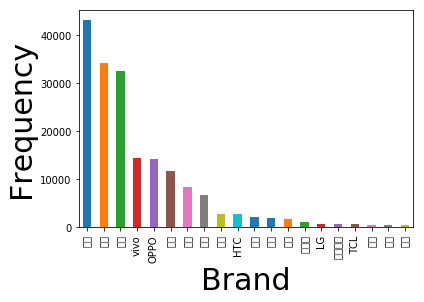

In [31]:
top20_brands = phone_brand_device_model.phone_brand.value_counts().head(20)

plt.xlabel('Brand', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
top20_brands.plot(kind='bar');
top20_brands

In [34]:
#mapping from kaggle
english_phone_brands_mapping = {
    "三星": "samsung",
    "天语": "Ktouch",
    "海信": "hisense",
    "联想": "lenovo",
    "欧比": "obi",
    "爱派尔": "ipair",
    "努比亚": "nubia",
    "优米": "youmi",
    "朵唯": "dowe",
    "黑米": "heymi",
    "锤子": "hammer",
    "酷比魔方": "koobee",
    "美图": "meitu",
    "尼比鲁": "nibilu",
    "一加": "oneplus",
    "优购": "yougo",
    "诺基亚": "nokia",
    "糖葫芦": "candy",
    "中国移动": "ccmc",
    "语信": "yuxin",
    "基伍": "kiwu",
    "青橙": "greeno",
    "华硕": "asus",
    "夏新": "panosonic",
    "维图": "weitu",
    "艾优尼": "aiyouni",
    "摩托罗拉": "moto",
    "乡米": "xiangmi",
    "米奇": "micky",
    "大可乐": "bigcola",
    "沃普丰": "wpf",
    "神舟": "hasse",
    "摩乐": "mole",
    "飞秒": "fs",
    "米歌": "mige",
    "富可视": "fks",
    "德赛": "desci",
    "梦米": "mengmi",
    "乐视": "lshi",
    "小杨树": "smallt",
    "纽曼": "newman",
    "邦华": "banghua",
    "E派": "epai",
    "易派": "epai",
    "普耐尔": "pner",
    "欧新": "ouxin",
    "西米": "ximi",
    "海尔": "haier",
    "波导": "bodao",
    "糯米": "nuomi",
    "唯米": "weimi",
    "酷珀": "kupo",
    "谷歌": "google",
    "昂达": "ada",
    "聆韵": "lingyun",
    "小米": "Xiaomi",
    "华为": "Huawei",
    "魅族": "Meizu",
    "中兴": "ZTE",
    "酷派": "Coolpad",
    "金立": "Gionee",
    "SUGAR": "SUGAR",
    "OPPO": "OPPO",
    "vivo": "vivo",
    "HTC": "HTC",
    "LG": "LG",
    "ZUK": "ZUK",
    "TCL": "TCL",
    "LOGO": "LOGO",
    "SUGAR": "SUGAR",
    "Lovme": "Lovme",
    "PPTV": "PPTV",
    "ZOYE": "ZOYE",
    "MIL": "MIL",
    "索尼" : "Sony",
    "欧博信" : "Opssom",
    "奇酷" : "Qiku",
    "酷比" : "CUBE",
    "康佳" : "Konka",
    "亿通" : "Yitong",
    "金星数码" : "JXD",
    "至尊宝" : "Monkey King",
    "百立丰" : "Hundred Li Feng",
    "贝尔丰" : "Bifer",
    "百加" : "Bacardi",
    "诺亚信" : "Noain",
    "广信" : "Kingsun",
    "世纪天元" : "Ctyon",
    "青葱" : "Cong",
    "果米" : "Taobao",
    "斐讯" : "Phicomm",
    "长虹" : "Changhong",
    "欧奇" : "Oukimobile",
    "先锋" : "XFPLAY",
    "台电" : "Teclast",
    "大Q" : "Daq",
    "蓝魔" : "Ramos",
    "奥克斯" : "AUX"
}

Translating brands for convenience.

Xiaomi     43107
samsung    34191
Huawei     32465
vivo       14342
OPPO       14239
Meizu      11816
Coolpad     8382
lenovo      6752
Gionee      2763
HTC         2675
Name: phone_brand, dtype: int64

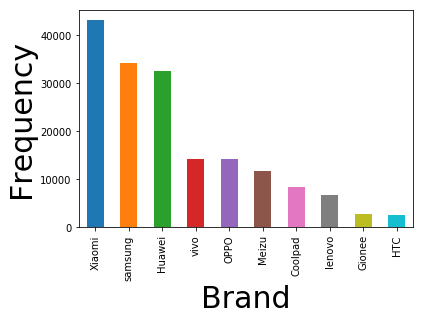

In [41]:
phone_brand_device_model['phone_brand'] = phone_brand_device_model['phone_brand'].replace(english_phone_brands_mapping)

top20_brands = phone_brand_device_model.phone_brand.value_counts().head(10)

plt.xlabel('Brand', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
top20_brands.plot(kind='bar');
top20_brands